In [1]:
import numpy as np
import sklearn
import os
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import torchcde

%load_ext autoreload
%autoreload 2

In [2]:
DATA_DIR = '/projectnb2/dl523/projects/trace_22/data/'
# DATASET_PICKLE = [traces, images, tokens, expressions]
path = os.path.join(DATA_DIR, 'cleaned/dataset_cleaned_125.pkl')

with open(path, 'rb') as f:
    dataset = pickle.load(f)
          
print((len(dataset), len(dataset[0])))

(4, 10939)


In [3]:
traces, images, tokens = dataset[0], dataset[1], dataset[2]

In [51]:
tr = traces[7278]
print(len(tr))

2


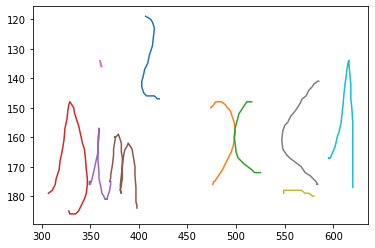

<Figure size 432x288 with 0 Axes>

In [55]:
for i in range(10):
    plt.plot(tr[0][i], tr[1][i])
plt.gca().invert_yaxis()
    
plt.show()
plt.savefig('segmented_traces.jpg')

In [50]:
tokens[7278]

'\\sin ^ 2 x \\leq 1\n'

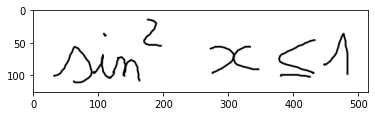

In [49]:
plt.imshow(images[7278], cmap='gray')

### Hold out

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(traces, tokens, test_size=1/4)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

8204
8204
2735
2735


### Cutoff tokens longer than length 150

Like mentioned in the paper (A Visual Latex Decompiler), we remove training samples with tokens longer than 150. However, we leave them in for testing.

We would thus remove 23 samples from the training set.

482
7271


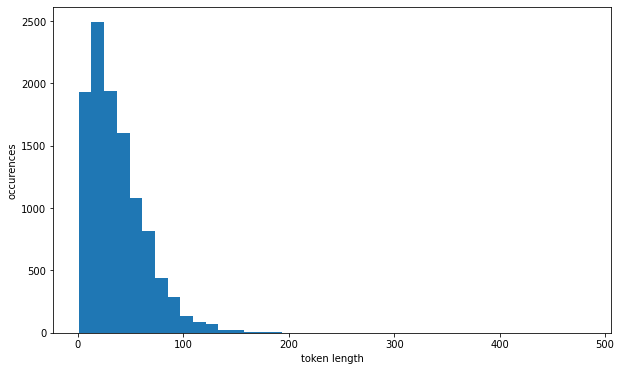

In [5]:
L = []

for tok in tokens:
    L.append(len(tok))
    
print(np.max(L))
print(np.argmax(L))
plt.figure(figsize=(10,6))
plt.hist(L, bins=40)
plt.ylabel('occurences')
plt.xlabel('token length')
plt.savefig('./figures/token_lengths.jpg')

In [5]:
def cutoff(X, y, token_length):
    '''Remove samples from X an y where y has a token length > 150.'''
    removed = []
    for idx in reversed(range(len(y))):
        if len(y[idx]) > token_length:
            print(idx)
            removed.append((X.pop(idx), y.pop(idx)))
    return removed
                           
rem = cutoff(X_train, y_train, token_length=150)

7725
7698
7664
7242
7140
7137
7043
7026
6674
6096
5806
5691
5618
3990
3192
2700
2684
2556
2365
389


In [6]:
len(X_train)

8184

### Load vocab

In [8]:
# load vocabulary
DATA = '/projectnb/dl523/projects/trace_22/data/'

vocab = np.load(DATA + 'labelencoding.npy')
vocab

array(['!', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '<', '=', '>', 'A', 'B', 'C', 'E',
       'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'V',
       'X', 'Y', '[', '\\', '\\!', '\\;', '\\Big', '\\Bigg', '\\Delta',
       '\\alpha', '\\beta', '\\cdot', '\\cdots', '\\cos', '\\div',
       '\\exists', '\\forall', '\\frac', '\\gamma', '\\geq', '\\gt',
       '\\hbox', '\\in', '\\infty', '\\int', '\\lambda', '\\lbrack',
       '\\ldots', '\\left', '\\leq', '\\lim', '\\limits', '\\log', '\\lt',
       '\\mathrm', '\\mbox', '\\mu', '\\neq', '\\parallel', '\\phi',
       '\\pi', '\\pm', '\\prime', '\\rbrack', '\\right', '\\rightarrow',
       '\\sigma', '\\sin', '\\sqrt', '\\sum', '\\tan', '\\theta',
       '\\times', '\\{', '\\}', ']', '^', '_', 'a', 'b', 'c', 'd', 'e',
       'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
       's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}'],
      dtype='<U11

### Visualize target lengths (i.e. how many tokens is one expression?)

## Dataset object

In [9]:
from tools.encode import train_label_encoding, OneHotEncoder

label_enc = train_label_encoding(vocab)

In [19]:
# distribution of trace lengths

# L = []
# for sample in train_X:
#     L.append(len(sample[1]))
    
# for sample in test_X:
#     L.append(len(sample[1]))

# for sample in traces:
#     L.append(len(sample[1]))
    
# max_trace_length = np.max(L)
max_trace_length = 7000
print(max_trace_length)

7000


In [68]:
traces[0].shape

(2, 4)

In [90]:
def process_trace(trace: np.ndarray,  skip_t=10, pad_len=7000, fill='last') -> np.ndarray:
    x, y = [], []
    timechannel = []
    current_t = 0
    for i in range(len(trace[0])):
        x.extend(trace[0][i])
        y.extend(trace[1][i])
        current_segment_times = np.arange(len(trace[0][i])).astype(float)
        timechannel.extend(current_t + current_segment_times)
        current_t = current_t + skip_t + current_segment_times[-1]
    unpadded = torch.tensor([timechannel, x, y])
    
    if fill=='nan':
        pad = torch.full((3, pad_len-unpadded.shape[1]), float('nan'))
    elif fill=='last':
        pad = unpadded[:,-1].unsqueeze(1).expand(-1, pad_len - unpadded.shape[1])
    else: raise ValueError()
    
    print(unpadded.shape)
    print(pad.shape)
    return torch.cat([unpadded,pad], dim=1).T
    
trace_tensor = process_trace(traces[2], skip_t=10, pad_len=7000)
print(trace_tensor)

torch.Size([3, 273])
torch.Size([3, 6727])
tensor([[0.0000e+00, 1.1411e+04, 9.5280e+03],
        [1.0000e+00, 1.1410e+04, 9.5260e+03],
        [2.0000e+00, 1.1405e+04, 9.5190e+03],
        ...,
        [3.0800e+02, 1.3933e+04, 1.0477e+04],
        [3.0800e+02, 1.3933e+04, 1.0477e+04],
        [3.0800e+02, 1.3933e+04, 1.0477e+04]], dtype=torch.float64)


In [91]:
trace_tensor.shape

torch.Size([7000, 3])

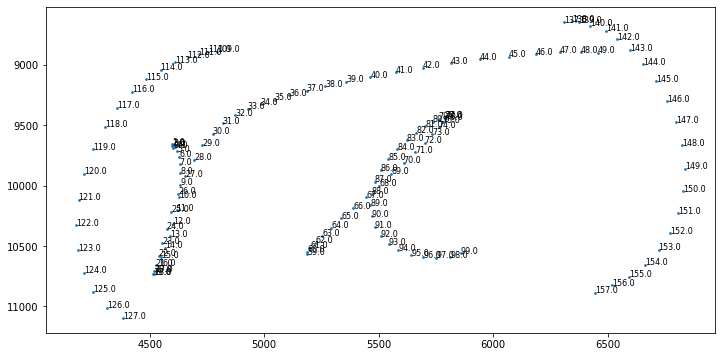

In [33]:
plt.figure(figsize=(12,6))
plt.scatter(trace_tensor.T[1], trace_tensor.T[2], s=3)

for i in range(trace_tensor.T.shape[1]):
    x, y = trace_tensor.T[1, i], trace_tensor.T[2, i]
    plt.annotate(trace_tensor.T[0, i].item(), (x, y), fontsize=8)
plt.gca().invert_yaxis()
plt.savefig('timechannel.jpg')

In [34]:
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader

# input_shape=(250, 490)

transform = process_trace

target_transform = OneHotEncoder(label_enc)

class TraceTokenDataset(Dataset):
    def __init__(self, traces, tokens, transform=transform, target_transform=target_transform, vocab=vocab):
        self.traces = traces
        self.tokens = tokens
        self.transform = transform
        self.target_transform = target_transform
        self.vocab = vocab

    def __len__(self):
        return len(self.traces)

    def __getitem__(self, idx):
        trace = self.traces[idx]
        target = self.tokens[idx]
        if self.transform:
            trace = self.transform(trace)
        if self.target_transform:
            target = self.target_transform(target)
        return trace, target
    
    
train_data = TraceTokenDataset(X_train, y_train, transform=transform, target_transform=target_transform, vocab=vocab)
    
test_data = TraceTokenDataset(X_test, y_test, transform=transform, target_transform=target_transform, vocab=vocab)

In [218]:
# train_X = []
# for d in train_data:
#         train_X.append(d[0].T)

# test_X = []
# for d in test_data:
#     test_X.append(d[0].T)
    
# train_y = []
# for i, d in enumerate(train_data):
#     train_y.append(d[1].T)
    
# print(train_y)

# test_y = []
# for d in test_data:
#     test_y.append(d[1].T)
    
# print(test_X[1].shape)

In [92]:
trainloader = DataLoader(train_data, batch_size=512, shuffle=True)
testloader = DataLoader(test_data, batch_size=512, shuffle=True)

In [93]:
class CDEFunc(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you!)
        ######################
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.linear1 = torch.nn.Linear(hidden_channels, 128)
        self.linear2 = torch.nn.Linear(128, input_channels * hidden_channels)

    ######################
    # For most purposes the t argument can probably be ignored; unless you want your CDE to behave differently at
    # different times, which would be unusual. But it's there if you need it!
    ######################
    def forward(self, t, z):
        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.relu()
        z = self.linear2(z)
        ######################
        # Easy-to-forget gotcha: Best results tend to be obtained by adding a final tanh nonlinearity.
        ######################
        z = z.tanh()
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        return z

In [94]:
class NeuralCDE(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, interpolation="cubic"):
        super(NeuralCDE, self).__init__()

        self.func = CDEFunc(input_channels, hidden_channels)
        self.initial = torch.nn.Linear(input_channels, hidden_channels)
        self.readout = torch.nn.Linear(hidden_channels, output_channels)
        self.interpolation = interpolation

    def forward(self, coeffs):
        if self.interpolation == 'cubic':
            X = torchcde.CubicSpline(coeffs)
        elif self.interpolation == 'linear':
            X = torchcde.LinearInterpolation(coeffs)
        else:
            raise ValueError("Only 'linear' and 'cubic' interpolation methods are implemented.")

        ######################
        # Easy to forget gotcha: Initial hidden state should be a function of the first observation.
        ######################
        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)

        ######################
        # Actually solve the CDE.
        ######################
        z_T = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.func,
                              t=X.interval)

        ######################
        # Both the initial value and the terminal value are returned from cdeint; extract just the terminal value,
        # and then apply a linear map.
        ######################
        z_T = z_T[:, 1]
        pred_y = F.sigmoid(self.readout(z_T))
        return pred_y


In [95]:
def train(trainloader, vocab_len, num_epochs=1, coeff_batch_size=128):
    
    criterion = nn.BCELoss()
    
    ######################
    # input_channels=3 because we have both the horizontal and vertical position of a point in the spiral, and time.
    # hidden_channels=8 is the number of hidden channels for the evolving z_t, which we get to choose.
    # output_channels=1 because we're doing binary classification.
    ######################
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = NeuralCDE(input_channels=3, hidden_channels=8, output_channels=vocab_len)
    model.to(device)
    print(model)
    optimizer = torch.optim.Adam(model.parameters())

    ######################
    # Now we turn our dataset into a continuous path. We do this here via Hermite cubic spline interpolation.
    # The resulting `train_coeffs` is a tensor describing the path.
    # For most problems, it's probably easiest to save this tensor and treat it as the dataset.
    ######################
  
    for idx, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
#         print(inputs)
        print(inputs.shape)        
        train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(inputs)
        print(train_coeffs.shape)
        print(train_coeffs)
        break
        train_dataset = torch.utils.data.TensorDataset(train_coeffs, train_y)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=coeff_batch_size)
        losses = []
        for epoch in range(num_epochs):
            for batch in train_dataloader:
                batch_coeffs, batch_y = batch
                batch_coeffs = batch_coeffs.to(device)
                batch_y = batch_y.to(device)
                pred_y = model(batch_coeffs).squeeze(-1)
                loss = criterion(pred_y, batch_y)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                losses.append(loss)
            print('Epoch: {}   Training loss: {}'.format(epoch, loss.item()))
        print('Finished Training')
        return model


def test(model, testLoader, threshold=0.5):
    test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(test_X).to(device)
    outputs = model(test_coeffs).squeeze(-1).to('cpu')
    
    correct = []
    total = []
    
    with torch.no_grad():
        for idx, data in enumerate(testLoader):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            
            for sample in range(len(outputs.cpu())):
                preds = np.where(outputs[sample].cpu()>threshold)[0]
                labels_ = np.where(labels[sample].cpu()==1)[0]
                if len(labels_) < 1:
                    continue
                intersection = set(preds) & set(labels_)
                total.append(len(labels_))
                correct.append(len(intersection))
        return np.array(correct), np.array(total)

In [96]:
vocab_len = len(vocab);
model, history = train(trainloader, vocab_len, coeff_batch_size=128)

cuda:0
NeuralCDE(
  (func): CDEFunc(
    (linear1): Linear(in_features=8, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=24, bias=True)
  )
  (initial): Linear(in_features=3, out_features=8, bias=True)
  (readout): Linear(in_features=8, out_features=126, bias=True)
)
torch.Size([512, 7000, 3])
torch.Size([512, 6999, 12])
tensor([[[ 0.0000e+00,  4.1000e+02,  2.0000e+02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.0000e+00,  3.9600e+02,  2.2300e+02,  ...,  0.0000e+00,
          -3.0000e+01,  4.8000e+01],
         [ 2.0000e+00,  3.9200e+02,  2.3000e+02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 2.8400e+02,  7.6100e+02,  1.9000e+02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.8400e+02,  7.6100e+02,  1.9000e+02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.8400e+02,  7.6100e+02,  1.9000e+02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]

TypeError: cannot unpack non-iterable NoneType object

## CDE Model

In [268]:
from cnn import Net

import torch.optim as optim
print('loading...')
net = Net(input_shape, vocab)

criterion = nn.BCELoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if we set the hardware to GPU in the Notebook settings, this should print a CUDA device:
# device = 'cpu'

print(device)

net.to(device)

loading...
cuda:0


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=115200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=126, bias=True)
)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    print('start')
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()   # zero the gradient buffers
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [238]:
def test_cnn(net, testLoader, threshold=0.5):
    correct = []
    total = []
    
    with torch.no_grad():
        for idx, data in enumerate(testLoader):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            
            for sample in range(len(outputs.cpu())):
                preds = np.where(outputs[sample].cpu()>threshold)[0]
                labels_ = np.where(labels[sample].cpu()==1)[0]
                if len(labels_) < 1:
                    continue
                intersection = set(preds) & set(labels_)
                total.append(len(labels_))
                correct.append(len(intersection))
        return np.array(correct), np.array(total)

In [243]:
correct, total = test_cnn(net, testloader)

In [240]:
len(correct)

2734

In [244]:
acc = correct / total

print(acc.std())
print(acc.mean())

0.24382155987974446
0.33117625994391686


# Cross validation with 5 folds

In [274]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5)
cv.get_n_splits(images, tokens)

ACC = []
HIST = []

BS = 28
    
data = ImgTokenDataset(images, tokens, transform=transform, target_transform=target_transform, vocab=vocab)
for fold, (train_index, test_index) in enumerate(cv.split(images)):
    
    HIST.append([])
    
    print('Fold: ', fold)
    # Setup data

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_index)

    trainloader = torch.utils.data.DataLoader(
                      data, 
                      batch_size=BS, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      data,
                      batch_size=BS, sampler=test_subsampler)

    # Model
    net = Net(input_shape, vocab)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.to(device)
    # Train
    for epoch in range(10):  # loop over the dataset multiple times
        print('Epoch: ', epoch)
        for i, d in enumerate(trainloader, 0):
            inputs, labels = d
        
            inputs, labels = inputs.to(device), labels.to(device)
            #inputs = inputs.cuda()
            #labels = labels.cuda()
            optimizer.zero_grad()   # zero the gradient buffers
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            if i % 50 == 49:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))
                HIST[fold].append(loss.item())
                
    correct, total = test_cnn(net, testloader)
    acc = correct / total

    print('Accuracy: ')
    print(f'{acc.mean():.3f} +/- {(acc.std()/2):.2f}')
    print()
    ACC.append(acc)
    
                      
print('Finished Training')

Fold:  0
Epoch:  0
[1,    50] loss: 0.199
[1,   100] loss: 0.185
[1,   150] loss: 0.179
[1,   200] loss: 0.197
[1,   250] loss: 0.173
[1,   300] loss: 0.175
Epoch:  1
[2,    50] loss: 0.158
[2,   100] loss: 0.166
[2,   150] loss: 0.143
[2,   200] loss: 0.179
[2,   250] loss: 0.173
[2,   300] loss: 0.176
Epoch:  2
[3,    50] loss: 0.163
[3,   100] loss: 0.154
[3,   150] loss: 0.165
[3,   200] loss: 0.155
[3,   250] loss: 0.146
[3,   300] loss: 0.153
Epoch:  3
[4,    50] loss: 0.148
[4,   100] loss: 0.162
[4,   150] loss: 0.133
[4,   200] loss: 0.137
[4,   250] loss: 0.143
[4,   300] loss: 0.162
Epoch:  4
[5,    50] loss: 0.156
[5,   100] loss: 0.146
[5,   150] loss: 0.128
[5,   200] loss: 0.149
[5,   250] loss: 0.136
[5,   300] loss: 0.148
Epoch:  5
[6,    50] loss: 0.146
[6,   100] loss: 0.143
[6,   150] loss: 0.135
[6,   200] loss: 0.131
[6,   250] loss: 0.147
[6,   300] loss: 0.124
Epoch:  6
[7,    50] loss: 0.117
[7,   100] loss: 0.139
[7,   150] loss: 0.140
[7,   200] loss: 0.138
[

In [296]:
mean_accs = []
for vals in ACC:
    mean_accs.append(np.mean(vals))

print(np.mean(mean_accs))
print(np.std(mean_accs))

0.34337621221654757
0.009582636488895168


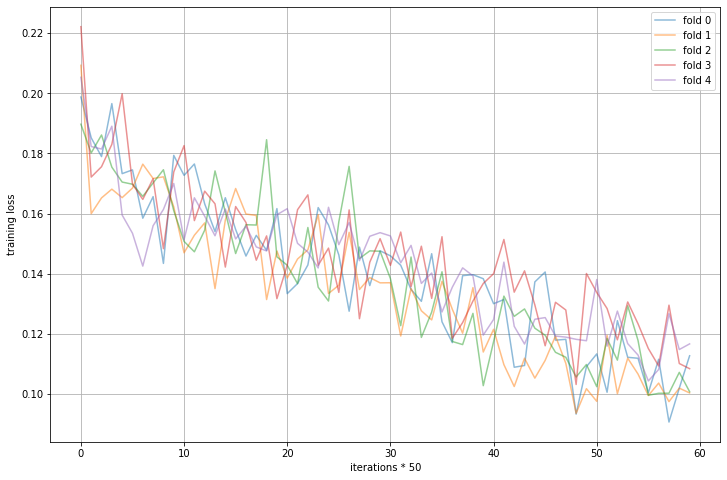

In [298]:
plt.figure(figsize=(12,8))

for fold in range(5):
    plt.plot(list(range(len(HIST[fold]))), HIST[fold], label=f'fold {fold}', alpha=0.5)
    
# plt.xticks(labels=str(50*np.arange(len(HIST[fold]))))
plt.xlabel('iterations * 50')
plt.ylabel('training loss')
plt.legend()
plt.grid()